### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [1]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1


In [2]:
import pandas as pd
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
#keep in mind that the file is encoded in UTF-8, so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(df.isna().sum())
df.info()

#excluding columns not relevant for our features
df = df[['Melding ID','Art - gruppe','Meldingsdato','Starttidspunkt','Havdybde start','Havdybde stopp','Rundvekt', "Art - FDIR"]]
df.head()
#taking note of the coloumns with missing values
print("Number of rows: ", df.shape[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

Melding ID                  305434
Meldingstidspunkt           305434
Meldingsdato                305434
Meldingsklokkeslett         305434
Starttidspunkt              305434
Startdato                   305434
Startklokkeslett            305434
Startposisjon bredde        305434
Startposisjon lengde        305434
Hovedområde start (kode)    303433
Hovedområde start           301310
Lokasjon start (kode)       303433
Havdybde start              305434
Stopptidspunkt              305434
Stoppdato                   305434
Stoppklokkeslett            305434
Varighet                    305434
Fangstår                    305434
Stopposisjon bredde         305434
Stopposisjon lengde         305434
Hovedområde stopp (kode)    303472
Hovedområde stopp           301310
Lokasjon stopp (kode)       303472
Havdybde stopp              305434
Trekkavstand                305410
Redskap FAO (kode)          305434
Redskap FAO                 305246
Redskap FDIR (kode)         305246
Redskap FDIR        

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the percentage of NaNs for each column
nanPercentage = df.isna().mean() * 100

nanPercentageDf = pd.DataFrame(nanPercentage.values.reshape(1, -1), columns=df.columns)

# Plotting the heatmap
plt.figure(figsize=(10, 1)) 
sns.heatmap(nanPercentageDf, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Percentage of NaN Values by Column")
plt.yticks([])

plt.show()

#this is for looking at the nanvalues in the dataset and how much of the dataset is missing of our specific columns. 

<class 'pandas.core.frame.DataFrame'>
Index: 227186 entries, 1 to 305433
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Art - gruppe         227186 non-null  object 
 1   Havdybde start       227186 non-null  int64  
 2   Havdybde stopp       227186 non-null  int64  
 3   Rundvekt             227186 non-null  float64
 4   Hovedområde start    227186 non-null  object 
 5   Hovedområde stopp    227186 non-null  object 
 6   Bruttotonnasje 1969  227186 non-null  float64
 7   Art - FDIR           227186 non-null  object 
 8   Redskap FDIR         227186 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.3+ MB


In [4]:
#checking every column for missing values and nan values
#print(df.isnull().sum())
print(df.isna().sum(), "\n")
print(df.isnull().sum())
#the 0 values and nan values are being counted the same as the nan values. So it wont be any collissions between the two. Assuming I can safely remove them

#removing the rows with missing values
df = df.dropna()
df.info()
print(df.isna().sum())
df.head()
print("Number of rows: ", df.shape[0])
df.head()

,Art - gruppe,Havdybde start,Havdybde stopp,Rundvekt,Hovedområde start,Hovedområde stopp,Bruttotonnasje 1969,Art - FDIR,Redskap FDIR
1,Hyse,-335,-334,9594.0,Bjørnøya,Bjørnøya,1476.0,Hyse,Bunntrål
2,Torsk,-335,-334,8510.0,Bjørnøya,Bjørnøya,1476.0,Torsk,Bunntrål
3,Blåkveite,-335,-334,196.0,Bjørnøya,Bjørnøya,1476.0,Blåkveite,Bunntrål


In [5]:
#counting total values of art gruppe
print(df['Art - gruppe'].value_counts() , "\n")
#counting total values of art fdir
print(df['Art - FDIR'].value_counts())

Art - gruppe
Torsk                                       41944
Annen torskefisk                            33439
Sei                                         31305
Hyse                                        30735
Uer                                         17828
Annen flatfisk, bunnfisk og dypvannsfisk    15369
Steinbiter                                  14706
Dypvannsreke                                 8506
Blåkveite                                    7049
Sild, annen                                  5386
Snøkrabbe                                    4135
Makrell                                      2780
Kolmule                                      2718
Skater og annen bruskfisk                    2542
Øyepål                                       1929
Annen pelagisk fisk                          1748
Vassild og strømsild                         1650
Lodde                                        1132
Tobis og annen sil                            819
Andre skalldyr, bløtdyr og pigghuder 

In [6]:
#finding out the difference between Art- gruppe and Art - FDIR
print(df['Art - gruppe'].unique(), "\n")
print(df['Art - FDIR'].unique())


Art - FDIR
Torsk             41944
Sei               31305
Hyse              30735
Lange             12577
Uer (vanlig)      12333
                  ...  
Storskate             1
Annen makrell         1
Spisskate             1
Skjeggtorsk           1
Rød kråkebolle        1
Name: count, Length: 104, dtype: int64


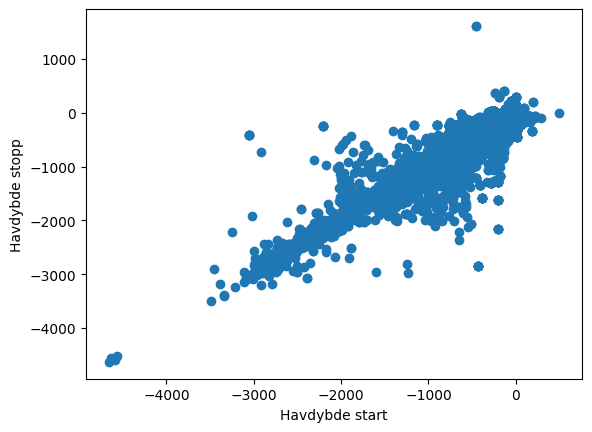

In [7]:
#checking if other will be overrepresented in the dataset
other_sum = df[~df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])].shape[0]
print("Sum of others: ", other_sum)
#counting torsk sei and hyse
print(df['Art - gruppe'].value_counts())
#it definitely will be overrepresented in the dataset. Do we want to remove it? It will certainly add model complexity.

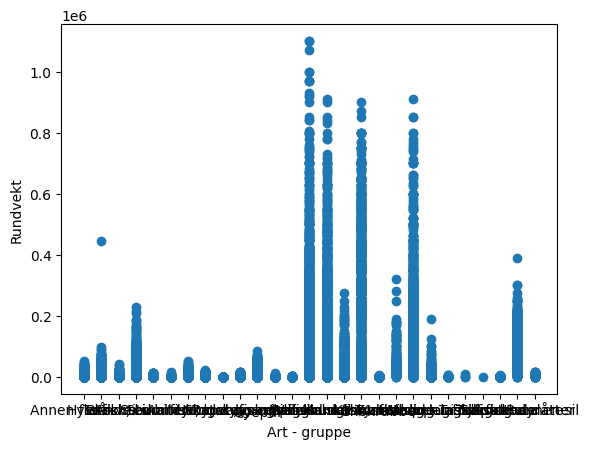

<class 'pandas.core.frame.DataFrame'>
Index: 227186 entries, 1 to 305433
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Art - gruppe         227186 non-null  object 
 1   Havdybde start       227186 non-null  int64  
 2   Havdybde stopp       227186 non-null  int64  
 3   Rundvekt             227186 non-null  float64
 4   Hovedområde start    227186 non-null  object 
 5   Hovedområde stopp    227186 non-null  object 
 6   Bruttotonnasje 1969  227186 non-null  float64
 7   Art - FDIR           227186 non-null  object 
 8   Redskap FDIR         227186 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.3+ MB


In [8]:
#counting number of rows
print("Number of rows: ", df.shape[0])
#realising that i havent dropped any rows since the number of rows are still the same
df.dropna(inplace=True)
print("New number of rows: ", df.shape[0])
#actually gonna drop all rows other than torsk, sei, hyse. Since we are only interested in these three species. The other are underrepresented and not relevant for our analysis.
df = df[df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])]
print("Only focusing on torsk sei hyse: ", df.shape[0])
df.head()
#so now we are working with %{df}.


In [9]:

#comparing art-gruppe and art-fdir to see if they are the same, counting the values
print(df['Art - gruppe'].value_counts(), "\n")
print(df['Art - FDIR'].value_counts())
#they are the same, so we can remove one of the columns.
#removing fdir
df = df.drop(columns=['Art - FDIR'])
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 227186 entries, 1 to 305433
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Art - gruppe         227186 non-null  object
 1   Havdybde start       227186 non-null  int64 
 2   Havdybde stopp       227186 non-null  int64 
 3   Rundvekt             227186 non-null  Int64 
 4   Hovedområde start    227186 non-null  object
 5   Hovedområde stopp    227186 non-null  object
 6   Bruttotonnasje 1969  227186 non-null  Int64 
 7   Art - FDIR           227186 non-null  object
 8   Redskap FDIR         227186 non-null  object
dtypes: Int64(2), int64(2), object(5)
memory usage: 17.8+ MB


In [ ]:
#presenting the count of the different species in the dataset with a barplot
sns.countplot(x='Art - gruppe', data=df)
plt.title('Count of species')
plt.show()

In [ ]:
#counting the unique number of boats
print(df['Melding ID'].unique())

In [ ]:
#plotting havdybde start and havdybde stopp using seaborn with different color for each species
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df, hue='Art - gruppe')
#viewing the plot and seeing it is so dense that it is hard to see the differences between the species. Additionally there are a lot of species over 0 which does not make sense when fishing.

#maybe we should use a threshold for the depth, since it is not possible to fish at 0 depth?
#then we will loose a lot of data points, so maybe there is a way to transform the outliers?
#But then again the transformed outliers will be useless since the initial values are not reliable? Are depth feature even reliable?


#note: Should probably transform the Art-gruppe to numerical values with one hot encoding.

#### This was more about learning about group function, aggregate and then concluding with pivot function will be most relevant


In [ ]:
#rows where Melding ID, Starttidspunkt are identical it's actually the same boat just casting different lines from the fishingboat
#We would have to transform data to represent the sameboat on a single row
#Each row with the same mentioned columns, are representing each row with a different fish. So they use rows to represent the same boat, but different fish
""" grouped = df.groupby(['Melding ID', 'Starttidspunkt', 'Startklokkeslett'])
print(grouped.size()) """
#realising its enough to group by Meldings ID
#grouped = df.groupby(['Melding ID', 'Meldingsdato','Starttidspunkt'])
#print(grouped.size())

#now I would have to aggregate the data where the size is greater than 1 into a single row, but also represent all the different fish in the same row
#Since the fish are in each of their own rows orginally, The new row would have to represent all the fish in the same row, with each fish in their own column
#I would have to use the pivot function to do this?  Trying with pivot


#now I want to aggregate the data where the size is greater than 1 into a single row
#code for this would be
aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

#dfNew = df.groupby(['Melding ID', 'Starttidspunkt']).agg(aggFunctions)
#transforming each group into a single row
#print(dfNew.head())

""" aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

dfNew = df.groupby('Melding ID','Starttidspunkt').agg(aggFunctions)
#transforming each group into a single row
print(dfNew.head()) """

#### This was more about solving the row problems

In [ ]:
grouped = dfNew.groupby(['Melding ID', 'Meldingsdato', 'Starttidspunkt'])
print(dfNew.grouped.size())

#realsing that the same boat is fishing further down in dataset, so we have to group differently.
#looking if the same boat gets a new id if its fishing again
""" print(dfNew['Melding ID'].value_counts(),"\n") """
#checking in old dataset
""" print(df['Melding ID'].value_counts()) """
#checking the unique values of the Melding ID in the old dataset
""" print(df['Melding ID'].nunique()) """
#this means its 4937 unique boats in the dataset
#I want to check if the same boat gets a new id if its fishing again
#checking the whole dataset
print(df['Melding ID'].value_counts())
""" Melding ID
1657367    54
1646724    50
1654624    46
1601430    44
1695415    44 """  
#this tells me it keeps the same id
#But then we would have to group by Melding ID, and Start


In [ ]:
#realising that the column Art - gruppe is a categorical variable, we can transform it into a one hot encoding
#this will allow us to use the column as a feature for our model
dfNew = pd.get_dummies(dfNew, columns=['Art - gruppe'])
print(dfNew.head())